In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:
train_X = pd.read_csv("train_X.csv").set_index('mid')
train_X_normalized = pd.read_csv("train_X_normalized.csv").set_index('mid')
train_X_extended = pd.read_csv("train_X_extended.csv").set_index('mid')
train_y = pd.read_csv('train_y.csv').set_index('mid')['radiant_win']

In [20]:
def print_max(results, param, limit = None):
    params = results['param_' + param]
    mean = results['mean_test_score']
    std = results['std_test_score']
        
    if limit is None:
        idx = np.argmax(mean)
        return f'{param}: {params[idx]}, score: {mean[idx]}, std: {std[idx]}'
    
    return results[results['mean_test_score'] > limit]

### (3 балла) Смешивание моделей (blending)

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания разных моделей. Давайте посмотрим, действительно ли такой подход дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) * \alpha + clf_2(x) * (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(2 балла) Задание 10.**
При реализации своих моделей хорошей практикой является создание sklearn-совместимых классов. Во-первых, такая реализация будет иметь стандартный интерфейс и позволит другим людям безболезненно обучать реализованные вами модели. Во-вторых, появляется возможность использовать любой функционал пакета sklearn, принимающий на вход модель, например, класс *GridSearchCV*, *learning_curve* и другие.

Создайте классификатор, который инициализируется двумя произвольными классификаторами и параметром $\alpha$. Во время обучения такой классификатор должен обучать обе базовые модели, а на этапе предсказания замешивать предсказания базовых моделей по формуле, указанной выше. 

Для создания пользовательского классификатора необходимо отнаследоваться от базовых классов *[BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), [ClassifierMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html)* и реализовать методы *\_\_init\_\_, fit, predict и predict_proba*. Пример sklearn-совместимого классификатора с комментариями можно найти [здесь](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) 

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
            self,
            a=0.5,
            *,
            estimator1,
            estimator2,
    ):
        self.a = a
        self.estimator1 = estimator1
        self.estimator2 = estimator2

    def fit(self, X, y):
        self.estimator1.fit(X, y)
        self.estimator2.fit(X, y)

        return self

    def predict(self, X):
        predict1 = self.estimator1.predict(X)
        predict2 = self.estimator2.predict(X)
        real_predict = self.a * predict1 + (1 - self.a) * predict2

        return real_predict

    def predict_proba(self, X):
        predict1 = self.estimator1.predict_proba(X)
        predict2 = self.estimator2.predict_proba(X)
        real_predict = self.a * predict1 + (1 - self.a) * predict2

        return real_predict

**(1 балл) Задание 11.** Подберите по сетке от 0 до 1 значение $\alpha$ для этого классификатора. Если класс реализован правильно, то вы cможете использовать *GridSearchCV*, как в случае с обычными классификаторами.

Изобразите на графике среднее качество по фолдам и доверительный интервал в зависимости от $\alpha$.

Дал ли этот подход прирост к качеству по сравнению с моделями, обученными по-отдельности? Поясните, почему даже простой блендинг моделей может влять на итоговое качество?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf1 = KNeighborsClassifier(n_neighbors=740, p=1, n_jobs=-1)
clf2 = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=-1)
clf3 = RandomForestClassifier(n_estimators=1546, criterion='entropy', n_jobs=-1)

pairs = [
    {'name': 'knn-sgd', 'estimator1': clf1, 'estimator2': clf2},
    {'name': 'knn-rfc', 'estimator1': clf1, 'estimator2': clf3},
    {'name': 'sgd-rfc', 'estimator1': clf2, 'estimator2': clf3},
]

a = np.arange(0.1, 1, 0.1)
params = {'a': a}
columns = ['mix'] + list(a)
results = []

for pair in pairs:
    name = pair['name']
    print(name)
    mix = MyClassifier(estimator1=pair['estimator1'], estimator2=pair['estimator2'])
    
    clf = GridSearchCV(mix, params, cv=5, n_jobs=-1, scoring='roc_auc')
    clf.fit(train_X_extended, train_y)
    results.append(clf.cv_results_)
;

In [11]:
import json
results = json.loads(pd.read_json("mix.json").to_json())

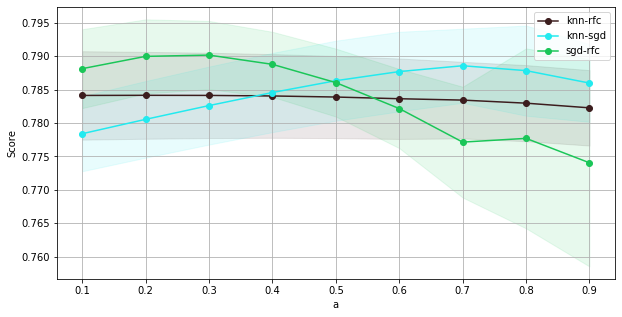

In [19]:
param = 'a'

plt.rcParams["figure.figsize"]=10,5

plt.grid()

for name in results:
    data = results[name]
    mean = np.array(data['mean_test_score'])
    std = np.array(data['std_test_score'])
    xasix = data['param_'+ param]
    rgb = np.random.rand(3,)
    plt.fill_between(xasix, mean - std, mean + std, alpha=0.1, color=rgb)
    plt.plot(xasix, mean, 'o-', color=rgb,
                 label=name)

plt.legend()
plt.xlabel(param)
plt.ylabel("Score")
plt.show()

In [25]:
for name in results:
    data = results[name]
    print(f"{name}: {print_max(data, 'a')}")

knn-rfc: a: 0.2, score: 0.7841423766, std: 0.0064993543
knn-sgd: a: 0.7, score: 0.7885657663, std: 0.0055425259
sgd-rfc: a: 0.3, score: 0.7901593835, std: 0.0051052853


Улучшить оценку лучшей модели не удалось, но все модели в итоге стали приближаться к лучшей. В целом простой блендинг позволяет лучше сглаживать выборсы и грубые ошибки каждой модели, тем самым иногда давая лучший скор 